### **Import required packages**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras import models, layers, optimizers
import matplotlib.image as mpimg
import math
import os
import warnings
warnings.filterwarnings('ignore')

### **Setting directory paths and initializing parameters**

In [2]:
BASE_DIR = '../input/intel-image-classification'
TRAIN_DIR = os.path.join(BASE_DIR, 'seg_train/seg_train')
TEST_DIR = os.path.join(BASE_DIR, 'seg_test/seg_test')
BATCH_SIZE = 32
EPOCHS = 20

#ImageDataGenerator for training data
TRAIN_DATAGEN = ImageDataGenerator(
                rescale = 1.0/255,
                validation_split = 0.2
                )

#ImageDataGenerator for testing data
TEST_DATAGEN = ImageDataGenerator(
                rescale = 1.0/255
                )

### **Displaying Images of each class**

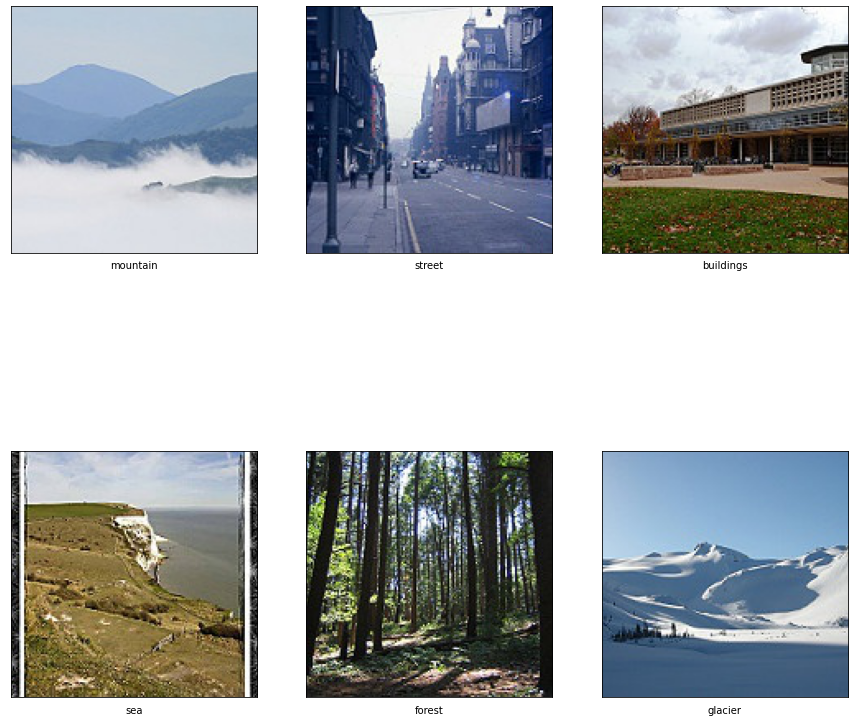

In [3]:
j=0
fig=plt.figure(figsize=(15, 15))
for i in os.listdir(TRAIN_DIR):
        img = mpimg.imread(TRAIN_DIR+"/"+i+"/"+os.listdir(TRAIN_DIR+"/"+i)[0])
        fig.add_subplot(2,3,j+1)
        plt.xticks([])
        plt.yticks([])
        plt.grid(False)
        plt.imshow(img, cmap=plt.cm.binary)
        plt.xlabel(i)
        j += 1
plt.show()

### **Image distribution of each class in train and test**

In [4]:
print("TRAINING DATA:")
for i in os.listdir(TRAIN_DIR):
    files = os.listdir(TRAIN_DIR+"/"+i)
    print(f'{i} : {len(files)} files')
    
print("\n\nTEST DATA:")
for i in os.listdir(TEST_DIR):
    files = os.listdir(TEST_DIR+"/"+i)
    print(f'{i} : {len(files)} files')

TRAINING DATA:
mountain : 2512 files
street : 2382 files
buildings : 2191 files
sea : 2274 files
forest : 2271 files
glacier : 2404 files


TEST DATA:
mountain : 525 files
street : 501 files
buildings : 437 files
sea : 510 files
forest : 474 files
glacier : 553 files


# **VGG16 Architecture**

### **Preparing Data**

In [5]:
train_generator = TRAIN_DATAGEN.flow_from_directory(
                    TRAIN_DIR,
                    target_size = (150,150),
                    batch_size = BATCH_SIZE,
                    class_mode = 'categorical',
                    subset='training'
                  )

validation_generator = TRAIN_DATAGEN.flow_from_directory(
                    TRAIN_DIR,
                    target_size = (150,150),
                    batch_size = BATCH_SIZE,
                    class_mode = 'categorical',
                    subset='validation'
                  )

test_generator = TEST_DATAGEN.flow_from_directory(
                    TEST_DIR,
                    target_size = (150,150),
                    batch_size = BATCH_SIZE,
                    class_mode = 'categorical'
                  )

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


### Loading VGG16 Model and freezing all its layer

In [6]:
conv_base = VGG16(
                    weights = 'imagenet',
                    include_top = False,
                    input_shape = (150,150,3)
                 )

58900480/58889256 [==============================] - 2s 0us/step


In [7]:
set_trainable = False
for layer in conv_base.layers:
    layer.trainable = False

In [8]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### Defining model with it's own classifier on top of VGG16 convolutional base.

In [9]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(6, activation='softmax'))

In [10]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=2e-5), metrics=['acc'])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 6)                 1542      
Total params: 16,813,638
Trainable params: 2,098,950
Non-trainable params: 14,714,688
_________________________________________________________________


In [12]:
history = model.fit_generator(
                                train_generator,
                                steps_per_epoch = train_generator.samples // BATCH_SIZE,
                                epochs = EPOCHS,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.samples // BATCH_SIZE,
                             )

Epoch 1/20
350/350 [==============================] - 83s 211ms/step - loss: 1.0254 - acc: 0.6192 - val_loss: 0.5741 - val_acc: 0.8125
Epoch 2/20
350/350 [==============================] - 23s 66ms/step - loss: 0.5801 - acc: 0.7951 - val_loss: 0.4607 - val_acc: 0.8394
Epoch 3/20
350/350 [==============================] - 23s 66ms/step - loss: 0.4824 - acc: 0.8243 - val_loss: 0.4153 - val_acc: 0.8552
Epoch 4/20
350/350 [==============================] - 23s 66ms/step - loss: 0.4322 - acc: 0.8472 - val_loss: 0.3908 - val_acc: 0.8646
Epoch 5/20
350/350 [==============================] - 22s 64ms/step - loss: 0.4031 - acc: 0.8556 - val_loss: 0.3733 - val_acc: 0.8696
Epoch 6/20
350/350 [==============================] - 23s 67ms/step - loss: 0.3741 - acc: 0.8694 - val_loss: 0.3600 - val_acc: 0.8736
Epoch 7/20
350/350 [==============================] - 23s 65ms/step - loss: 0.3566 - acc: 0.8747 - val_loss: 0.3506 - val_acc: 0.8736
Epoch 8/20
350/350 [==============================] - 23s 65m

In [13]:
def plot_acc_loss(history):

    train_acc = history.history['acc']
    val_acc = history.history['val_acc']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs = range(1, len(train_acc)+1)

    plt.plot(epochs, train_acc, label='Training accuracy')
    plt.plot(epochs, val_acc, label='Validation accuracy', color='red')
    plt.title("Training and Validation Accuracy")
    plt.legend()
    plt.figure()

    plt.plot(epochs, train_loss, label='Training loss')
    plt.plot(epochs, val_loss, label='Validation loss', color='red')
    plt.title("Training and Validation loss")
    plt.legend()
    plt.show()
    print("Average Validation loss: ", np.mean(val_loss))
    print(f"Average Validation accuracy: {np.mean(val_acc)*100:.2f} %")

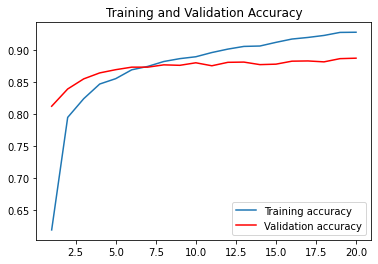

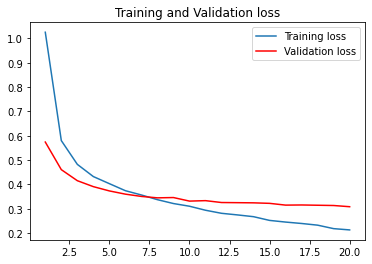

Average Validation loss:  0.3571824446320534
Average Validation accuracy: 87.19 %


In [14]:
plot_acc_loss(history)

### Testset Accuracy before fine-tuning

In [15]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Accuracy before fine tuning: {test_acc*100:.2f} %")

Test Accuracy before fine tuning: 88.44 %


## **Fine Tuning**

In [16]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name=='block5_conv1':
        set_trainable = True
    if set_trainable == True:
        layer.trainable = True
    else:
        layer.trainable = False

In [17]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [18]:
model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(lr=1e-5), metrics=['acc'])
history = model.fit_generator(
                                train_generator,
                                steps_per_epoch = train_generator.samples // BATCH_SIZE,
                                epochs = EPOCHS,
                                validation_data = validation_generator,
                                validation_steps = validation_generator.samples // BATCH_SIZE,
                             )

Epoch 1/20
350/350 [==============================] - 25s 68ms/step - loss: 0.1957 - acc: 0.9280 - val_loss: 0.2936 - val_acc: 0.8969
Epoch 2/20
350/350 [==============================] - 23s 65ms/step - loss: 0.1458 - acc: 0.9511 - val_loss: 0.2856 - val_acc: 0.9041
Epoch 3/20
350/350 [==============================] - 24s 67ms/step - loss: 0.1108 - acc: 0.9645 - val_loss: 0.2806 - val_acc: 0.9009
Epoch 4/20
350/350 [==============================] - 23s 66ms/step - loss: 0.0864 - acc: 0.9713 - val_loss: 0.2817 - val_acc: 0.9073
Epoch 5/20
350/350 [==============================] - 23s 65ms/step - loss: 0.0662 - acc: 0.9804 - val_loss: 0.3070 - val_acc: 0.9062
Epoch 6/20
350/350 [==============================] - 24s 68ms/step - loss: 0.0509 - acc: 0.9854 - val_loss: 0.3111 - val_acc: 0.9019
Epoch 7/20
350/350 [==============================] - 23s 66ms/step - loss: 0.0387 - acc: 0.9914 - val_loss: 0.3083 - val_acc: 0.9080
Epoch 8/20
350/350 [==============================] - 24s 70ms

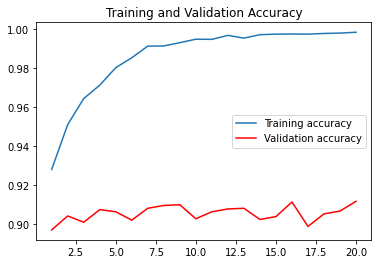

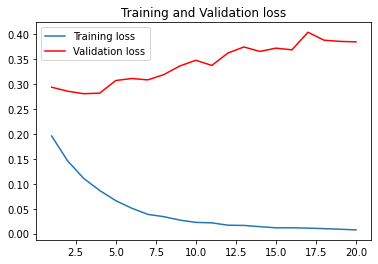

Average Validation loss:  0.3406193032860756
Average Validation accuracy: 90.54 %


In [19]:
plot_acc_loss(history)

### Testset Accuracy after fine-tuning

In [20]:
test_loss, test_acc = model.evaluate_generator(test_generator, steps=test_generator.samples // BATCH_SIZE)
print(f"Test Accuracy after fine tuning: {test_acc*100:.2f} %")

Test Accuracy after fine tuning: 91.06 %
